In [1]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
import os
import pandas as pd
import sys
from meteostat import Point, Hourly

In [2]:
module_path = os.path.abspath(os.path.join('../..', 'utils'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ml_tools import add_weekends_holidays

d:\CS\summer_project\comp47360-group8\ml_pipeline\utils


In [3]:
# Turn off GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
data = TimeSeriesDataFrame.from_pickle("patch_tst_small_df.pkl")
predictor = TimeSeriesPredictor.load("patch_tst_small_model_files")

In [5]:
def make_weather_df():
    start =  pd.to_datetime('2024-06-01')
    end = pd.Timestamp.now() + pd.DateOffset(weeks=2)
    point = Point(40.7789, -73.9692) # Central park USW00094728 station
    data = Hourly(point, start, end)
    df = data.fetch()
    # fill missing precip values with 0
    df.loc[df['prcp'].isna(), 'prcp'] = 0

    # Fill missing weather condition codes with 2
    df.loc[df['coco'].isna(), 'coco'] = 2
    # Drop wind speed and wind direction
    df = df.drop(['wspd', 'wdir', 'wpgt', 'snow', 'tsun'], axis=1)
    df = df.reset_index()
    return df.rename({'time': 'timestamp'}, axis=1)


In [6]:
def make_open_hours_df():
    df_open = pd.read_csv("../../data_preparation/taxi_location_num_businesses_open/taxi_location_num_businesses_open.csv")
    df_open = df_open.rename({'location':'item_id'},axis=1)
    return df_open.set_index(['day', 'hour', 'item_id'])
    

In [7]:
df_wth = make_weather_df()

In [8]:
df_wth

,timestamp,temp,dwpt,rhum,prcp,pres,coco
0,2024-06-01 00:00:00,21.7,5.6,35.0,0.0,1019.8,1.0
1,2024-06-01 01:00:00,21.1,5.0,35.0,0.0,1020.6,1.0
2,2024-06-01 02:00:00,20.6,3.8,33.0,0.0,1020.9,3.0
3,2024-06-01 03:00:00,19.0,5.1,40.0,0.0,1022.0,1.0
4,2024-06-01 04:00:00,18.9,4.3,38.0,0.0,1021.1,1.0
...,...,...,...,...,...,...,...
1355,2024-07-27 11:00:00,24.7,19.8,74.0,0.0,1016.1,2.0
1356,2024-07-27 12:00:00,24.5,18.9,71.0,0.0,1015.1,2.0
1357,2024-07-27 13:00:00,25.5,18.7,66.0,0.0,1015.2,2.0
1358,2024-07-27 14:00:00,26.5,18.4,61.0,0.0,1015.3,2.0


In [9]:
def make_known_covariates(data, predictor):
    future_index = get_forecast_horizon_index_ts_dataframe(data, prediction_length=predictor.prediction_length, freq='H')
    future_timestamps = future_index.get_level_values("timestamp").to_series()
    known_covariates = pd.DataFrame(index=future_index)
    known_covariates['day'] = future_timestamps.dt.day_name().str.lower().values
    known_covariates['hour'] = future_timestamps.dt.hour.to_list()
    df_open = make_open_hours_df()
    known_covariates = known_covariates.join(df_open, on=['day', 'hour', 'item_id'])
    df_wth = make_weather_df()
    known_covariates = known_covariates.join(df_wth.set_index("timestamp"), on='timestamp', how='left')
    add_weekends_holidays(known_covariates)
    return known_covariates

In [10]:
known_covariates = make_known_covariates(data, predictor)

In [11]:
known_covariates

day  hour  food  alcohol  leisure  temp  dwpt  \
item_id timestamp                                                               
4       2024-04-01 00:00:00  monday     0   0.0      0.0      0.0   NaN   NaN   
        2024-04-01 01:00:00  monday     1   1.0      0.0      0.0   NaN   NaN   
        2024-04-01 02:00:00  monday     2   1.0      0.0      0.0   NaN   NaN   
        2024-04-01 03:00:00  monday     3   1.0      0.0      0.0   NaN   NaN   
        2024-04-01 04:00:00  monday     4   1.0      0.0      0.0   NaN   NaN   
...                             ...   ...   ...      ...      ...   ...   ...   
263     2024-07-29 19:00:00  monday    19  66.0      1.0      0.0   NaN   NaN   
        2024-07-29 20:00:00  monday    20  61.0      1.0      0.0   NaN   NaN   
        2024-07-29 21:00:00  monday    21  55.0      1.0      0.0   NaN   NaN   
        2024-07-29 22:00:00  monday    22  20.0      1.0      0.0   NaN   NaN   
        2024-07-29 23:00:00  monday    23   6.0      1.0      0.0   NaN   NaN   

                             rhum  prcp  pres  coco  weekend  holiday  
item_id timestamp                                                      
4       2024-04-01 00:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
        2024-04-01 01:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
        2024-04-01 02:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
        2024-04-01 03:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
        2024-04-01 04:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
...                           ...   ...   ...   ...      ...      ...  
263     2024-07-29 19:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
        2024-07-29 20:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
        2024-07-29 21:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
        2024-07-29 22:00:00   NaN   NaN   NaN   NaN      0.0      0.0  
        2024-07-29 23:00:00   NaN   NaN   NaN   NaN      0.0      0.0  

[198720 rows x 13 columns]

In [12]:
data

busyness  food  alcohol  leisure  temp  dwpt  \
item_id timestamp                                                           
4       2021-01-01 00:00:00       234   0.0      0.0      0.0   4.0  -4.0   
        2021-01-01 01:00:00       315   1.0      0.0      0.0   3.0  -4.0   
        2021-01-01 02:00:00       263   1.0      0.0      0.0   3.0  -4.0   
        2021-01-01 03:00:00       216   1.0      0.0      0.0   2.0  -3.9   
        2021-01-01 04:00:00       130   1.0      0.0      0.0   2.0  -5.0   
...                               ...   ...      ...      ...   ...   ...   
263     2024-03-31 19:00:00       575  70.0      3.0      0.0  16.1  -0.6   
        2024-03-31 20:00:00       608  66.0      3.0      0.0  16.1  -1.0   
        2024-03-31 21:00:00       602  58.0      3.0      0.0  15.6  -0.6   
        2024-03-31 22:00:00       486  22.0      3.0      0.0  14.4  -1.3   
        2024-03-31 23:00:00       320   6.0      3.0      0.0  14.0  -0.8   

                             rhum  prcp    pres coco  weekend  holiday  
item_id timestamp                                                       
4       2021-01-01 00:00:00  56.0   0.0  1026.3  4.0      0.0      1.0  
        2021-01-01 01:00:00  60.0   0.0  1027.7  4.0      0.0      1.0  
        2021-01-01 02:00:00  60.0   0.0  1028.1  4.0      0.0      1.0  
        2021-01-01 03:00:00  65.0   0.0  1029.2  3.0      0.0      1.0  
        2021-01-01 04:00:00  60.0   0.0  1029.9  3.0      0.0      1.0  
...                           ...   ...     ...  ...      ...      ...  
263     2024-03-31 19:00:00  32.0   0.0  1011.6  2.0      1.0      0.0  
        2024-03-31 20:00:00  31.0   0.0  1011.9  1.0      1.0      0.0  
        2024-03-31 21:00:00  33.0   0.0  1012.6  3.0      1.0      0.0  
        2024-03-31 22:00:00  34.0   0.0  1013.1  3.0      1.0      0.0  
        2024-03-31 23:00:00  36.0   0.0  1015.0  3.0      1.0      0.0  

[1871357 rows x 12 columns]

In [13]:
predictions = predictor.predict(data, known_covariates=known_covariates)

data with frequency 'None' has been resampled to frequency 'h'.


In [14]:
predictions

mean         0.1         0.2         0.3  \
item_id timestamp                                                             
4       2024-04-01 00:00:00  167.929733   97.800896  122.965401  140.219650   
        2024-04-01 01:00:00  175.251129   64.710648  103.920158  131.163544   
        2024-04-01 02:00:00  141.984467   37.811714   74.872444  100.535454   
        2024-04-01 03:00:00   71.981850  -14.246888   16.655201   37.874706   
        2024-04-01 04:00:00   41.767597  -14.995749    5.460146   19.416859   
...                                 ...         ...         ...         ...   
263     2024-07-29 19:00:00  584.621887  405.911102  471.312103  515.144836   
        2024-07-29 20:00:00  566.912781  396.655029  459.433167  501.139923   
        2024-07-29 21:00:00  522.893127  366.569824  423.862946  462.195251   
        2024-07-29 22:00:00  435.379974  289.482544  342.485718  378.312836   
        2024-07-29 23:00:00  300.917664  196.264587  234.622940  260.284790   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
4       2024-04-01 00:00:00  154.613571  167.929733  181.245895  195.639832   
        2024-04-01 01:00:00  154.034866  175.251129  196.467407  219.338715   
        2024-04-01 02:00:00  122.045135  141.984467  161.923813  183.433502   
        2024-04-01 03:00:00   55.589001   71.981850   88.374702  106.088989   
        2024-04-01 04:00:00   31.032526   41.767597   52.502678   64.118340   
...                                 ...         ...         ...         ...   
263     2024-07-29 19:00:00  551.315552  584.621887  617.928284  654.098938   
        2024-07-29 20:00:00  535.411804  566.912781  598.413696  632.685608   
        2024-07-29 21:00:00  493.800781  522.893127  551.985535  583.591003   
        2024-07-29 22:00:00  407.997864  435.379974  462.762115  492.447144   
        2024-07-29 23:00:00  281.442596  300.917664  320.392761  341.550537   

                                    0.8         0.9  
item_id timestamp                                    
4       2024-04-01 00:00:00  212.894073  238.058578  
        2024-04-01 01:00:00  246.582108  285.791595  
        2024-04-01 02:00:00  209.096497  246.157211  
        2024-04-01 03:00:00  127.308495  158.210571  
        2024-04-01 04:00:00   78.075050   98.530937  
...                                 ...         ...  
263     2024-07-29 19:00:00  697.931641  763.332642  
        2024-07-29 20:00:00  674.392395  737.170471  
        2024-07-29 21:00:00  621.923340  679.216492  
        2024-07-29 22:00:00  528.274292  581.277344  
        2024-07-29 23:00:00  367.212402  405.570770  

[198720 rows x 10 columns]

data with frequency 'None' has been resampled to frequency 'h'.


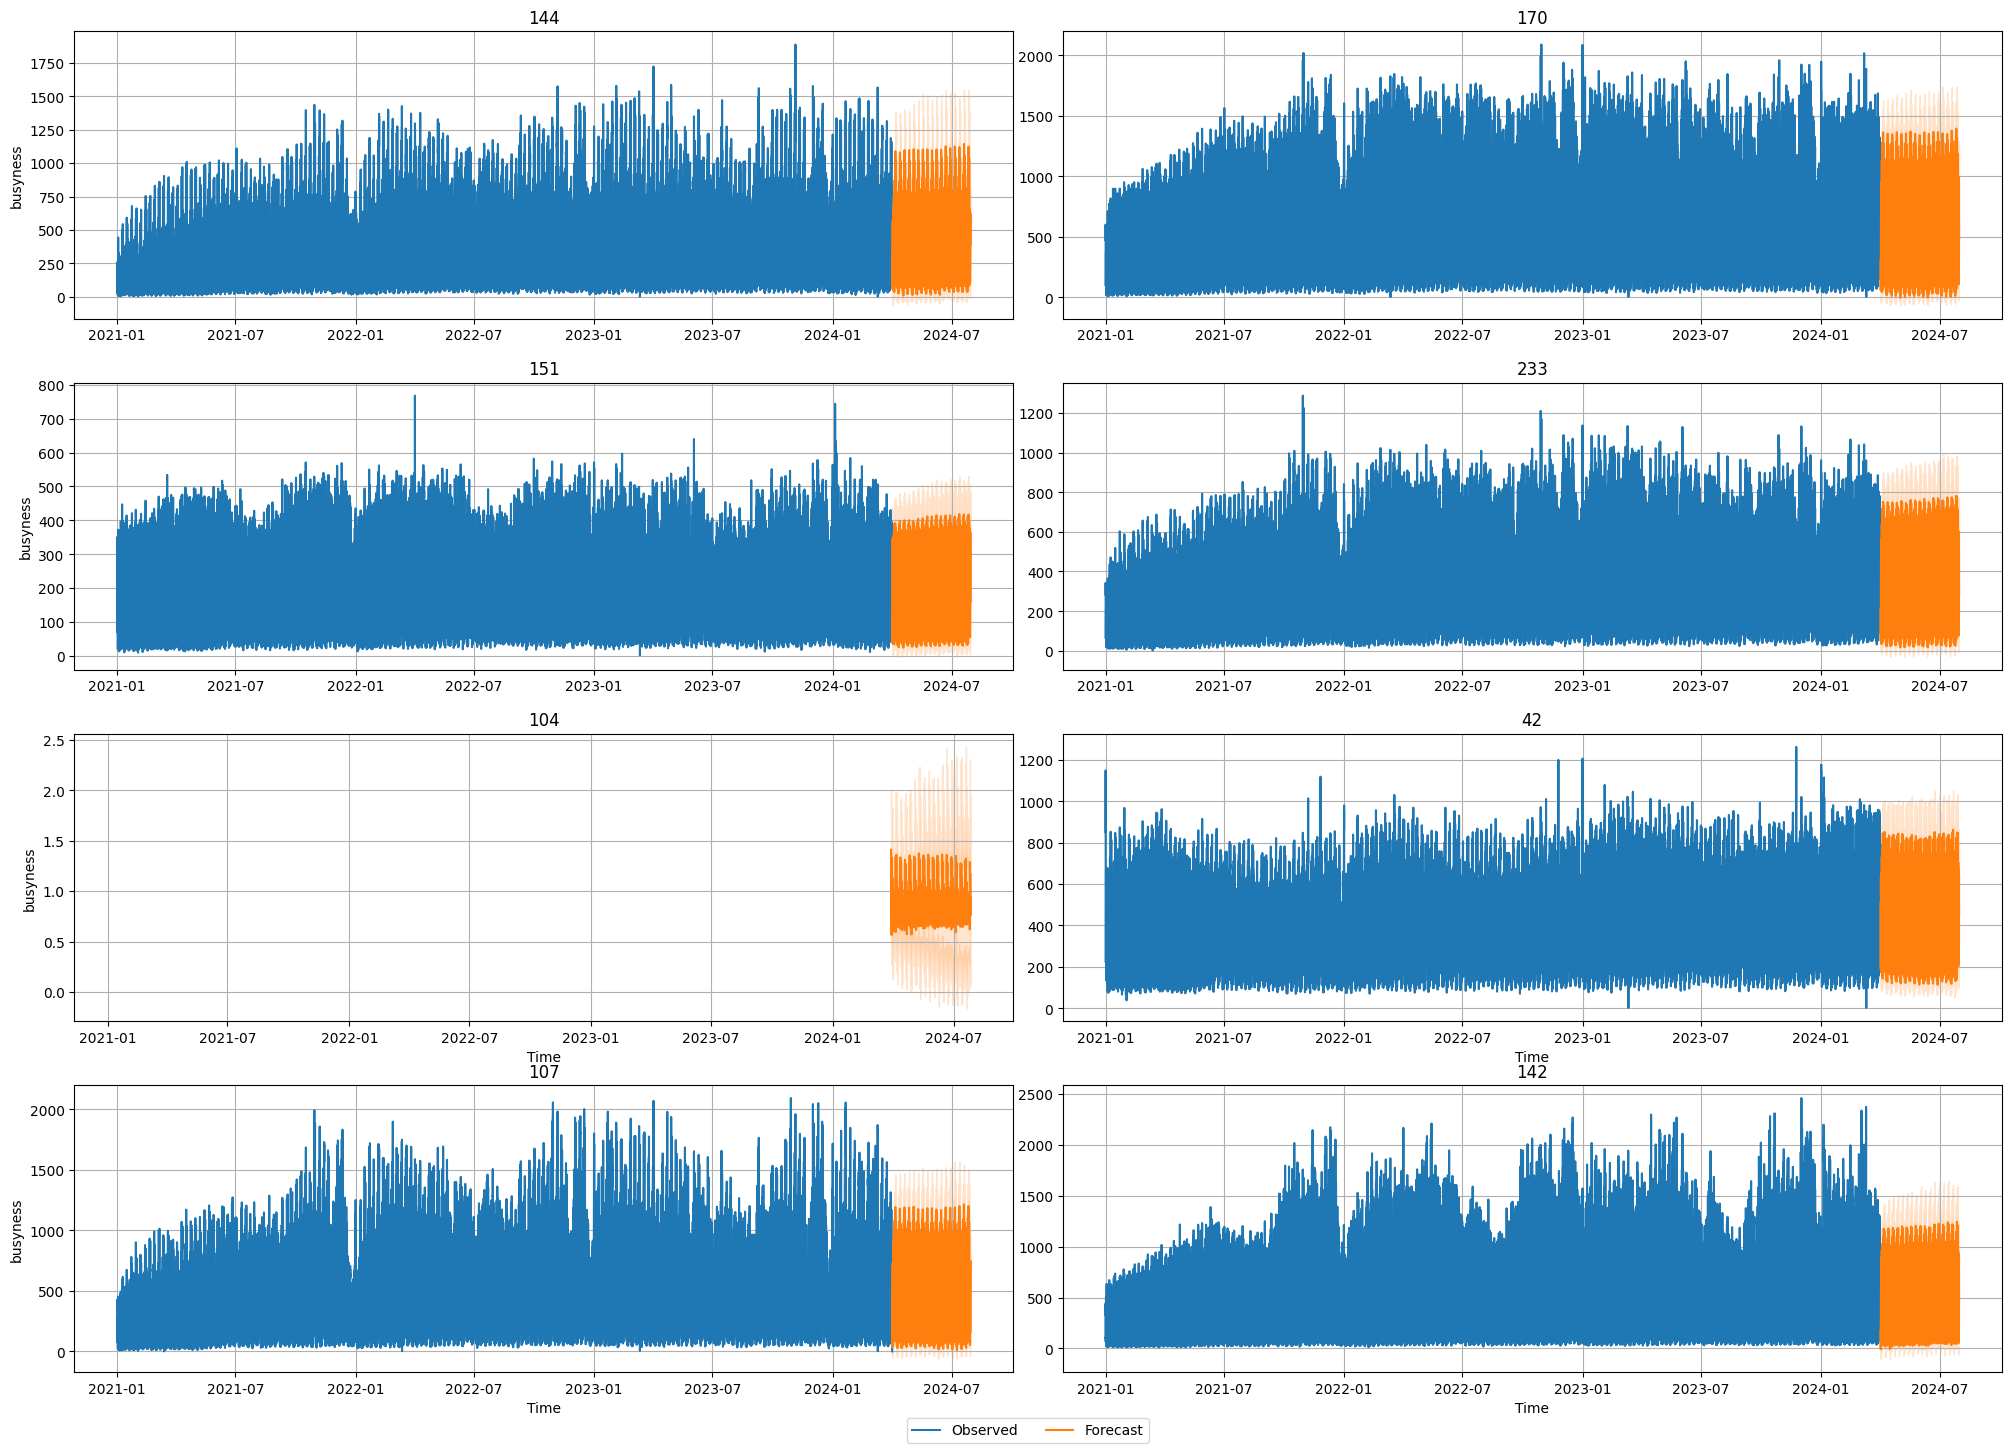

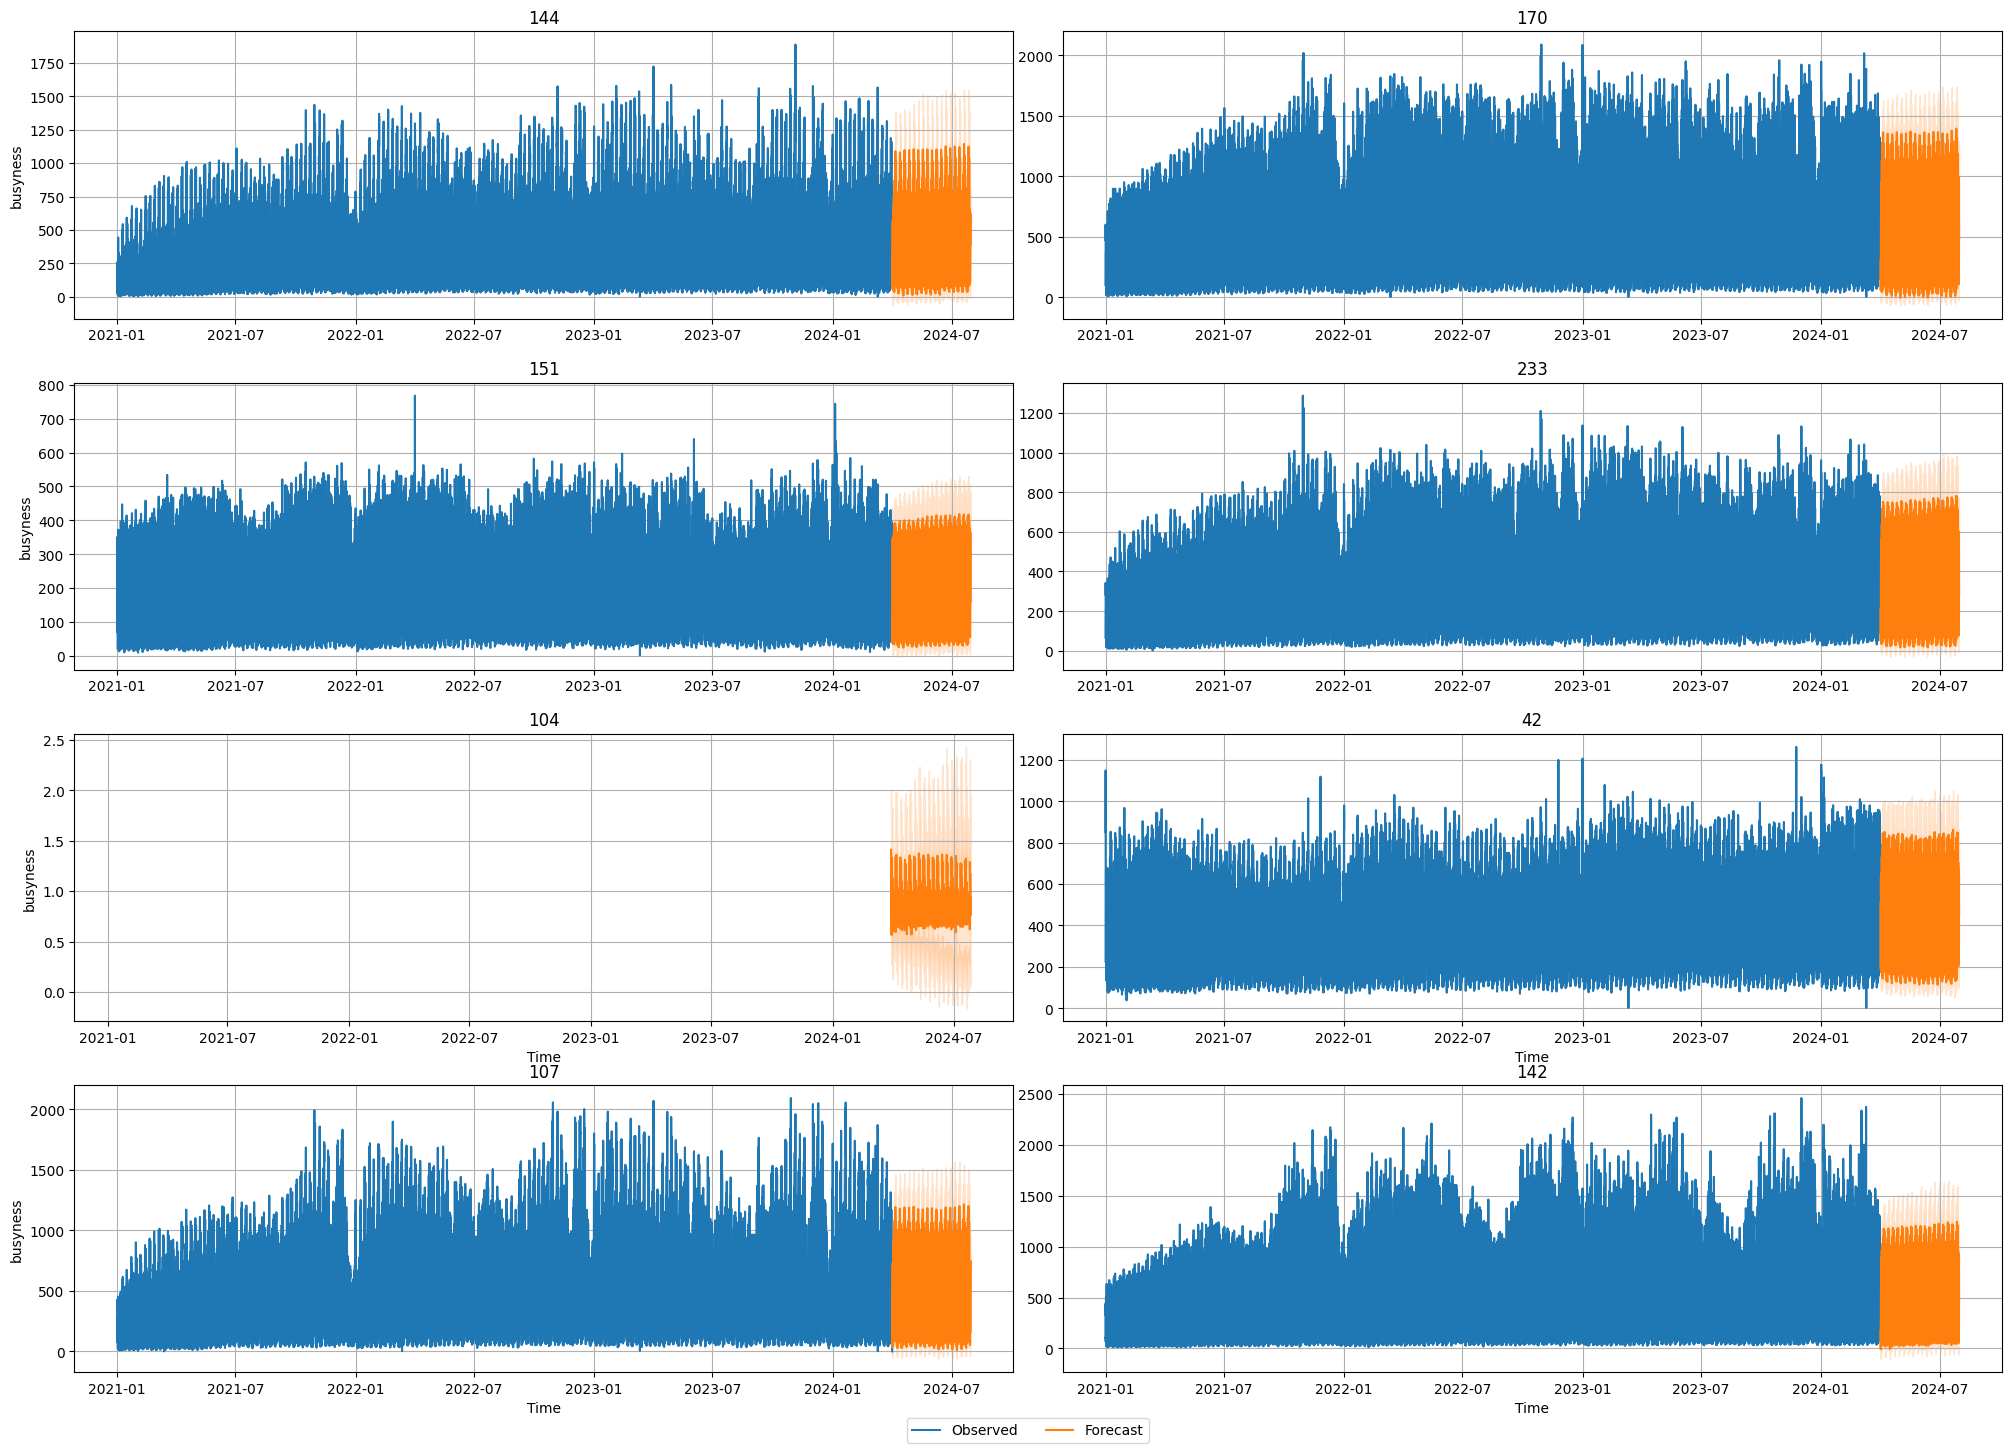

In [15]:
predictor.plot(data, predictions)